# Import

In [1]:
import pandas as pd
import os
import rasterio
import geopandas as gpd
import spacv
import matplotlib.pyplot as plt
import numpy as np

from shapely import wkt
from shapely.geometry.point import Point

from IAdeforestation.preprocessing import *
from IAdeforestation.spatial_cross_val import *

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Shapefile import

In [2]:
LABELS_PATH = 'labels'
SHAPEFILES_PATHS = [os.path.join(LABELS_PATH, 'central_highlands_1_other', 'central_highlands_1_other.shp'),
 os.path.join(LABELS_PATH, 'central_highlands_2_test', 'central_highlands_2_test.shp'),
 os.path.join(LABELS_PATH, 'central_highlands_2_other', 'central_highlands_2_other.shp')]

SHAPEFILE_ESPG=4326

points = process_shapefile(SHAPEFILES_PATHS)

In [3]:
coords, labels = zip(*points)

In [4]:
coords_points = []
plt.show
for p in coords:
    coords_points.append(Point(p[0],p[1]))

In [5]:
vietnam = gpd.read_file("district/diaphanhuyen.shp")

In [6]:
geo_df = gpd.GeoDataFrame({'geometry':coords_points, 'labels':labels})

In [7]:
geo_df

,geometry,labels
0,POINT (107.94103 14.43993),6
1,POINT (107.93873 14.44076),6
2,POINT (107.94177 14.43879),6
3,POINT (107.94323 14.43819),6
4,POINT (107.94079 14.43759),6
...,...,...
10264,POINT (107.89111 11.55182),17
10265,POINT (107.89070 11.55158),17
10266,POINT (107.89042 11.55184),17
10267,POINT (107.89034 11.55139),17


# Shapefile on Vietnam map

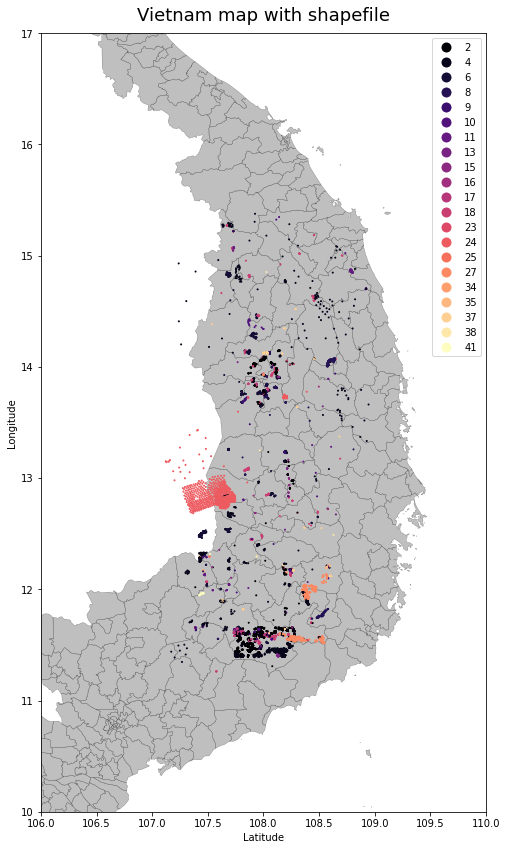

In [8]:
fig, ax = plt.subplots(figsize=(12,12))

vietnam.plot(ax=ax,facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)
geo_df.plot(ax=ax, markersize=1,categorical=True, legend=True, column="labels", cmap="magma")
ax.set_ylim([10,17])
ax.set_xlim([106,110])
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
fig.suptitle("Vietnam map with shapefile", fontsize=18)
fig.tight_layout()

In [9]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'spring_train.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

data_test = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'spring_test.csv')))
data_test['geometry'] = data_test['geometry'].apply(wkt.loads)

# Train validation test split

Fold 1 Number coffee - train : 225
Fold 1 Number no-coffee - train : 771
Fold 1 Number coffee - val : 63
Fold 1 Number no-coffee - val : 295
-----
Fold 2 Number coffee - train : 378
Fold 2 Number no-coffee - train : 1034
Fold 2 Number coffee - val : 19
Fold 2 Number no-coffee - val : 111
-----
Fold 3 Number coffee - train : 391
Fold 3 Number no-coffee - train : 920
Fold 3 Number coffee - val : 5
Fold 3 Number no-coffee - val : 218
-----
Fold 4 Number coffee - train : 375
Fold 4 Number no-coffee - train : 823
Fold 4 Number coffee - val : 20
Fold 4 Number no-coffee - val : 322
-----
Fold 5 Number coffee - train : 81
Fold 5 Number no-coffee - train : 868
Fold 5 Number coffee - val : 290
Fold 5 Number no-coffee - val : 199
-----
Number coffee - test : 101
Number no-coffee - test : 418
-----


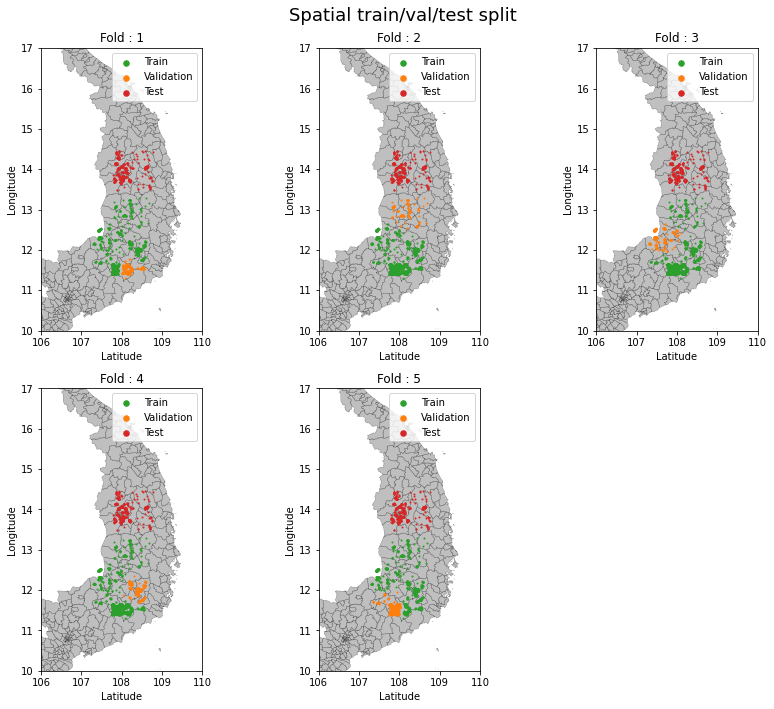

In [10]:
skcv = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(data_train['geometry'])
fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=3)

axes = axes.flatten()

i = 0

for train, validation in skcv:
    ax = axes[i]
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    print(f"Fold {i+1} Number coffee - train : {len(geo_train[geo_train['label'] == 2])}")
    print(f"Fold {i+1} Number no-coffee - train : {len(geo_train[geo_train['label'] != 2])}")

    print(f"Fold {i+1} Number coffee - val : {len(geo_val[geo_val['label'] == 2])}")
    print(f"Fold {i+1} Number no-coffee - val : {len(geo_val[geo_val['label'] != 2])}")
    print("-----")
    
    vietnam.plot(ax=ax,facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)

    
    geo_train.plot(ax=ax, markersize=1,categorical=True, legend=True, c="tab:green")
    geo_val.plot(ax=ax, markersize=1,categorical=True, legend=True, c="tab:orange")
    data_test.plot(ax=ax,markersize=1,categorical=True, legend=True, c="tab:red")

    ax.set_ylim([10,17])
    ax.set_xlim([106,110])
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Longitude")
    ax.set_title(f"Fold : {i+1}")
    fig.suptitle("Spatial train/val/test split", fontsize=18)
    legend = ax.legend(["Train", "Validation", "Test"])
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]
    legend.legendHandles[2]._sizes = [30]

    fig.tight_layout()
    i+=1
    
fig.delaxes(ax= axes[-1]) 
print(f"Number coffee - test : {len(data_test[data_test['label'] == 2])}")
print(f"Number no-coffee - test : {len(data_test[data_test['label'] != 2])}")
print("-----")

# Coffee repartition

In [49]:
def display_cross_val_map_class(data_train, data_val, maps, title, xlim=[106,110], ylim=[10,16], figsize=(12,6)):
    fig, axes = plt.subplots(1,2,figsize=figsize)

    maps.plot(ax=axes[0],facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)
    maps.plot(ax=axes[1],facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)

    data_train[data_train['label'] == 0].plot(ax=axes[0], markersize=1,categorical=True, legend=True, c="tab:green")
    data_val[data_val['label'] == 0].plot(ax=axes[0], markersize=1,categorical=True, legend=True, c="tab:orange")
    
    data_train[data_train['label'] == 1].plot(ax=axes[1], markersize=1,categorical=True, legend=True, c="tab:pink")
    data_val[data_val['label'] == 1].plot(ax=axes[1], markersize=1,categorical=True, legend=True, c="tab:blue")

    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)

    axes[0].set_xlabel("Latitude")
    axes[0].set_ylabel("Longitude")
    
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)

    axes[1].set_xlabel("Latitude")
    axes[1].set_ylabel("Longitude")

    legend = axes[0].legend(["Train coffee", "Val coffee"])
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]
    
    legend = axes[1].legend(["Train other", "Val other"])
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]

    fig.suptitle(title)

In [52]:
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_all.csv')))
all_data['geometry'] = all_data['geometry'].apply(wkt.loads)

all_data.loc[all_data['label'] != 2, 'label'] = 1
all_data.loc[all_data['label'] == 2, 'label'] = 0

coffee_data = all_data[all_data['label'] == 0].reset_index(drop=True)
other_data = all_data[all_data['label'] == 1].reset_index(drop=True)

Fold 1 Number coffee - train : 186
Fold 1 Number no-coffee - train : 1305
Fold 1 Number coffee - val : 289
Fold 1 Number no-coffee - val : 216
-----
Fold 2 Number coffee - train : 397
Fold 2 Number no-coffee - train : 1189
Fold 2 Number coffee - val : 101
Fold 2 Number no-coffee - val : 367
-----
Fold 3 Number coffee - train : 481
Fold 3 Number no-coffee - train : 1289
Fold 3 Number coffee - val : 17
Fold 3 Number no-coffee - val : 269
-----
Fold 4 Number coffee - train : 476
Fold 4 Number no-coffee - train : 1063
Fold 4 Number coffee - val : 22
Fold 4 Number no-coffee - val : 456
-----
Fold 5 Number coffee - train : 342
Fold 5 Number no-coffee - train : 1260
Fold 5 Number coffee - val : 69
Fold 5 Number no-coffee - val : 255
-----


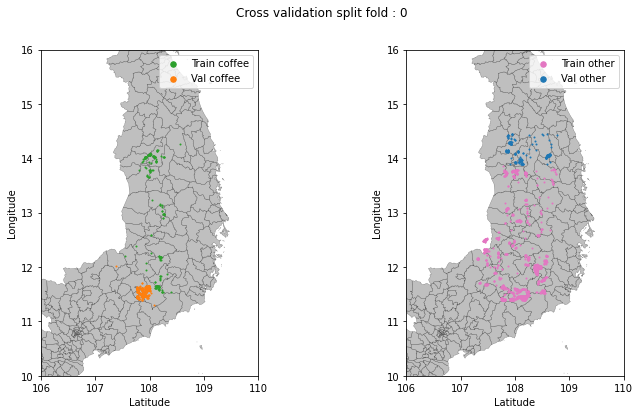

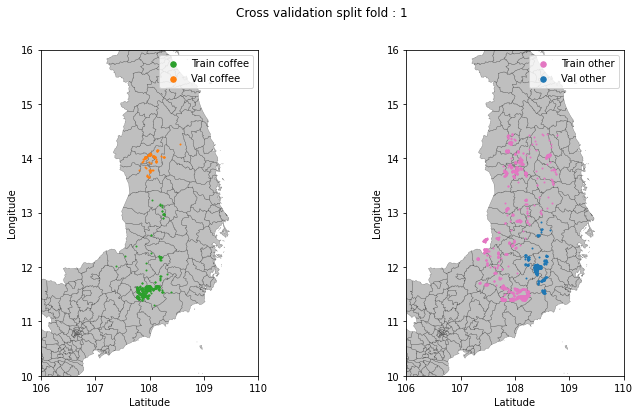

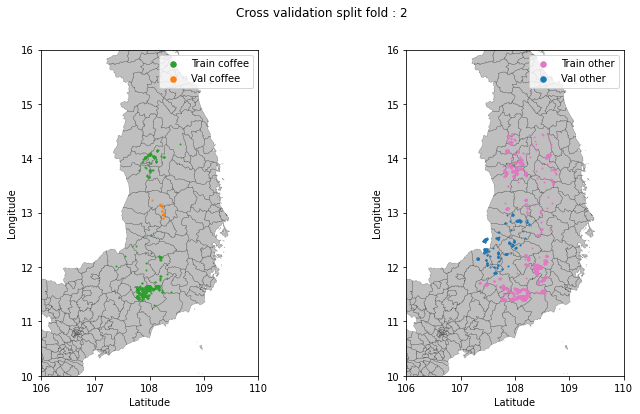

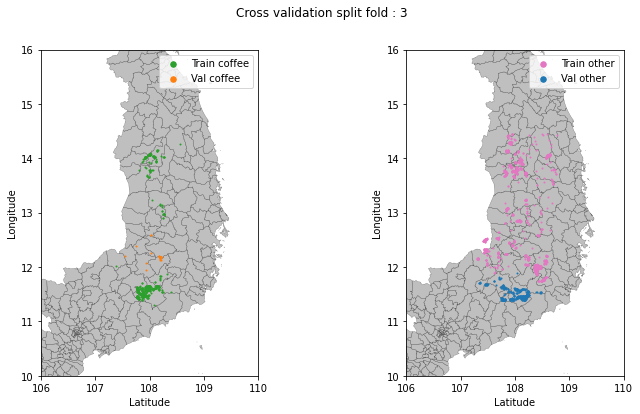

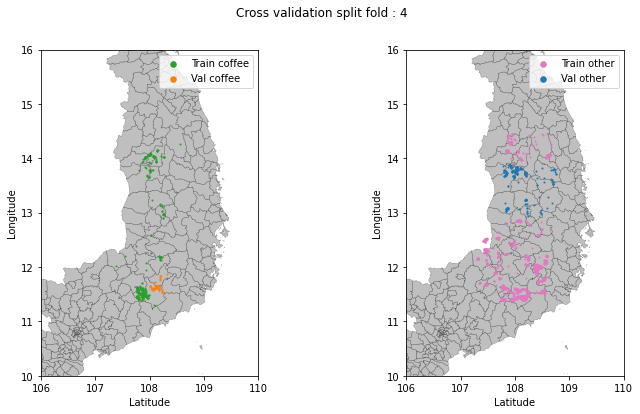

In [53]:
skcv_coffee = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(coffee_data['geometry'])
skcv_other = spacv.SKCV(n_splits=5, buffer_radius=0.1).split(other_data['geometry'])

i = 0

for coffee, other in zip(skcv_coffee, skcv_other):

    geo_train = coffee_data.iloc[coffee[0]].append(other_data.iloc[other[0]], ignore_index=True)
    geo_val = coffee_data.iloc[coffee[1]].append(other_data.iloc[other[1]], ignore_index=True)
    

    print(f"Fold {i+1} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i+1} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i+1} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i+1} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print("-----")

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {i}")
    i+=1

# Stratified Spatial Cross val

In [215]:
len(train_data[train_data['label'] == 0])

397

In [216]:
len(train_data[train_data['label'] == 1])

1145

In [218]:
len(test_data[test_data['label'] == 0])

101

In [219]:
len(test_data[test_data['label'] == 1])

418

In [217]:
train_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_train.csv')))
train_data['geometry'] = train_data['geometry'].apply(wkt.loads)

train_data.loc[train_data['label'] != 2, 'label'] = 1
train_data.loc[train_data['label'] == 2, 'label'] = 0

test_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'spring_test.csv')))
test_data['geometry'] = test_data['geometry'].apply(wkt.loads)

test_data.loc[test_data['label'] != 2, 'label'] = 1
test_data.loc[test_data['label'] == 2, 'label'] = 0

In [220]:
nb_labels = train_data['label'].value_counts().to_dict()
prop0 = nb_labels[0]/(nb_labels[0]+nb_labels[1])
prop1 = nb_labels[1]/(nb_labels[0]+nb_labels[1])

print(prop0)
print(prop1)

0.25745784695201035
0.7425421530479897


In [221]:
nb_labels

{1: 1145, 0: 397}

In [222]:
def compute_mean_point(df):
    coord_x = []
    coord_y = []
    
    for p in df['geometry'].to_numpy():
        coord_x.append(p.x)
        coord_y.append(p.y)
        
    return (np.mean(coord_x), np.mean(coord_y))

In [223]:
def find_nearest_points(mean_point, df_points, nb_to_draw):
    dict_points = {}
    for p in df_points.iterrows():
        current_point = p[1]['geometry']
        dict_points[p[0]] = np.sqrt((mean_point[0] - current_point.x) ** 2 + (mean_point[1] - current_point.y) ** 2)
        
    sorted_dict = dict(sorted(dict_points.items(), key=lambda item: item[1]))
    return list(sorted_dict)[0:nb_to_draw]

In [257]:
def stratified_df(geo_train, geo_val, nb_labels, nb_fold=5):
    
    prop0 = nb_labels[0]/nb_fold
    prop1 = nb_labels[1]/nb_fold
    
    nb_train0 = len(geo_train[geo_train['label'] ==0])
    nb_val0 = len(geo_val[geo_val['label'] ==0])

    
    mean_train = compute_mean_point(geo_train)
    mean_val = compute_mean_point(geo_val)
    
    if np.abs(nb_val0 - prop0) < 5 :
        pass
    else:
        if nb_val0 < prop0:
            print('nb_val0 < prop0')
            nb_to_draw = int(prop0 - nb_val0)
            
            index_to_switch = find_nearest_points(mean_val, geo_train[geo_train['label'] == 0], nb_to_draw)
            rows = geo_train.loc[index_to_switch]
            geo_train = geo_train.drop(index_to_switch, inplace=False, axis='index')
            
            geo_val = geo_val.append(rows, ignore_index=True)
        else :

            nb_to_draw = int(nb_val0 - prop0)
            
            index_to_switch = find_nearest_points(mean_train, geo_val[geo_val['label'] == 0], nb_to_draw)
            rows = geo_val.loc[index_to_switch]
            geo_val = geo_val.drop(index_to_switch, inplace=False, axis='index')
            
            geo_train = geo_train.append(rows, ignore_index=True)
            
    nb_train1 = len(geo_train[geo_train['label'] ==1])
    nb_val1 = len(geo_val[geo_val['label'] ==1])

    if np.abs(nb_val1 - prop1) < 5 :
        pass
    else:
        if nb_val1 < prop1:
            nb_to_draw = int(prop1 - nb_val1)
            
            index_to_switch = find_nearest_points(mean_val, geo_train[geo_train['label'] ==1], nb_to_draw)
            rows = geo_train.loc[index_to_switch]
            geo_train = geo_train.drop(index_to_switch, inplace=False, axis='index')
            
            geo_val = geo_val.append(rows, ignore_index=True)
        else :
            nb_to_draw = int(nb_val1 - prop1)
            
            index_to_switch = find_nearest_points(mean_train, geo_val[geo_val['label'] == 1], nb_to_draw)
            rows = geo_val.loc[index_to_switch]
            geo_val = geo_val.drop(index_to_switch, inplace=False, axis='index')
            
            geo_train = geo_train.append(rows, ignore_index=True)
                             
    return (geo_train, geo_val)

nb_val0 < prop0
317
909
0.25856443719412725
0.7414355628058727
79
229
0.2564935064935065
0.7435064935064936
-------
288
837
0.256
0.744
80
229
0.2588996763754045
0.7411003236245954
-------
nb_val0 < prop0
317
916
0.2570965125709651
0.7429034874290349
79
229
0.2564935064935065
0.7435064935064936
-------
nb_val0 < prop0
318
916
0.2576985413290113
0.7423014586709886
79
229
0.2564935064935065
0.7435064935064936
-------
nb_val0 < prop0
225
833
0.21266540642722118
0.7873345935727788
79
229
0.2564935064935065
0.7435064935064936
-------


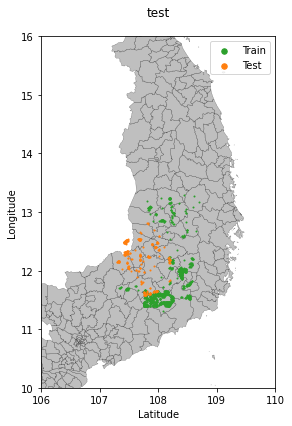

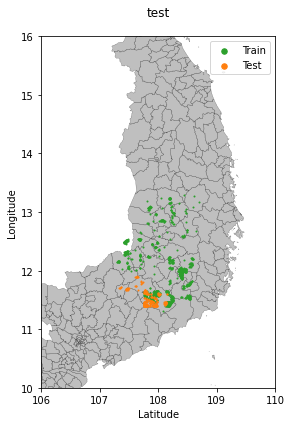

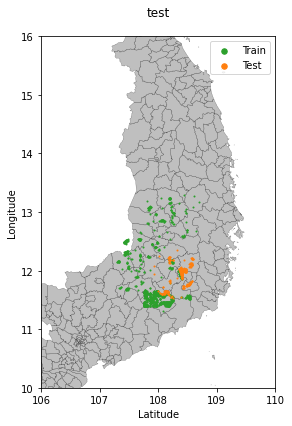

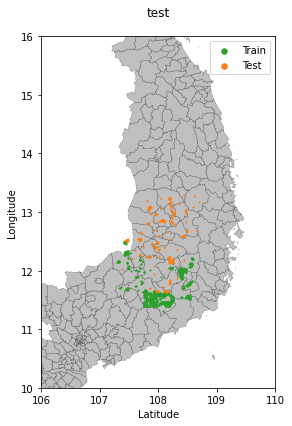

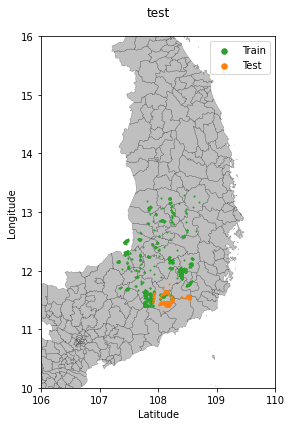

In [258]:
NB_FOLD = 5

skcv = spacv.SKCV(n_splits=NB_FOLD, buffer_radius=0.1).split(train_data['geometry'])

fold_index = 0

results = []

for train, validation in skcv:
    geo_train = train_data.iloc[train]
    geo_val = train_data.iloc[validation]

    
    geo_train, geo_val = stratified_df(geo_train, geo_val, nb_labels, NB_FOLD)
    
    len0 = len(geo_train[geo_train['label'] ==0])
    len1 = len(geo_train[geo_train['label'] ==1])
    print(len0)
    print(len1)
    print(len0/(len0+len1))
    print(len1/(len0+len1))

    
    len0 = len(geo_val[geo_val['label'] ==0])
    len1 = len(geo_val[geo_val['label'] ==1])
    print(len0)
    print(len1)
    print(len0/(len0+len1))
    print(len1/(len0+len1))
    print("-------")
    
    
    display_cross_val_map(geo_train, geo_val, vietnam, "test")